In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [258]:
pip install catboost

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 99.2/99.2 MB 6.4 MB/s eta 0:00:00


In [106]:
client = pd.read_csv("/content/client_data.csv")
price = pd.read_csv("/content/price_data.csv")

**Dataset `client`**: 14,606 records √ó 26 features  
**Dataset `price`**: 193,002 records √ó 8 features

In [107]:
client.shape

(14606, 26)

In [108]:
price.shape

(193002, 8)

# **Core Business Challenge**


The energy provider faces significant churn, impacting revenue,

We need to:

- **Identify** at-risk customers before they churn
- **Understand** the key drivers behind churn decisions


**Primary Hypothesis**:

Price sensitivity is a significant driver of customer churn, where:
- Customers experiencing price increases are more likely to churn
- Price volatility correlates with higher attrition rates
- Certain pricing periods (peak/off-peak) have stronger churn effects

#### Key Questions to Address

##### 1. Price Impact Analysis
- What is the elasticity of churn relative to price changes?
- Do certain price components (fixed vs. variable) have greater impact?
- How does price sensitivity vary by customer segment?

##### 2. Behavioral Patterns
- How do consumption trends differ between churning and loyal customers?
- What contract characteristics (duration, renewal timing) affect retention?
- Does product/service bundling reduce price sensitivity?

In [109]:
client.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0         0         54946                0  2013-06-15  2016-06-15   
1      4660             0                0  2009-08-21  2016-08-30   
2       544             0                0  2010-04-16  2016-04-16   
3      1584             0                0  2010-03-30  2016-03-30   
4      4425             0              526  2010-01-13  2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  has_gas  imp_cons  \
0      2015-11-01   2015-06-23               0.00  ...        t      0.00   
1      2009-08-21   2015-08-31             189.95  ...        f      0.00   
2      2010-04-16   2015-04-17              47.96  ...        f      0.00   
3      2010-03-30   2015-03-31             240.04  ...        f      0.00   
4      2010-01-13   2015-03-09             445.75  ...        f     52.32   

   margin_gross_pow_ele  margin_net_pow_ele  nb_prod_act  net_margin  \
0                 25.44               25.44            2      678.99   
1                 16.38               16.38            1       18.89   
2                 28.60               28.60            1        6.60   
3                 30.22               30.22            1       25.46   
4                 44.91               44.91            1       47.98   

  num_years_antig                         origin_up  pow_max  churn  
0               3  lxidpiddsbxsbosboudacockeimpuepw    43.65      1  
1               6  kamkkxfxxuwbdslkwifmmcsiusiuosws    13.80      0  
2               6  kamkkxfxxuwbdslkwifmmcsiusiuosws    13.86      0  
3               6  kamkkxfxxuwbdslkwifmmcsiusiuosws    13.20      0  
4               6  kamkkxfxxuwbdslkwifmmcsiusiuosws    19.80      0  

[5 rows x 26 columns]

In [110]:
price.head()

id  price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745  2015-01-01                0.15   
1  038af19179925da21a25619c5a24b745  2015-02-01                0.15   
2  038af19179925da21a25619c5a24b745  2015-03-01                0.15   
3  038af19179925da21a25619c5a24b745  2015-04-01                0.15   
4  038af19179925da21a25619c5a24b745  2015-05-01                0.15   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0            0.00                0.00               44.27            0.00   
1            0.00                0.00               44.27            0.00   
2            0.00                0.00               44.27            0.00   
3            0.00                0.00               44.27            0.00   
4            0.00                0.00               44.27            0.00   

   price_mid_peak_fix  
0                0.00  
1                0.00  
2                0.00  
3                0.00  
4                0.00

# **Exploratory Data Analysis**

**Client Dataset**

- id = client company identifier
- channel_sales = code of the sales channel
- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month
- date_activ = date of activation of the contract
- date_end = registered date of the end of the contract
- date_modif_prod = date of the last modification of the product
- date_renewal = date of the next contract renewal
- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year
- forecast_discount_energy = forecasted value of current discount
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
- has_gas = indicated if client is also a gas
- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)
- origin_up = code of the electricity campaign the customer first subscribed to
- pow_max = subscribed power
- churn = has the client churned over the next 3 months




In [111]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

**Price Dataset**

- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)

In [112]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


## **Univariate Analysis : Client Dataset**

**Churn**

Even a low churn rate (9.7%) can have a major financial impact if lost customers are high consumers.

In [113]:
client['churn'].value_counts().reset_index()

churn  count
0      0  13187
1      1   1419

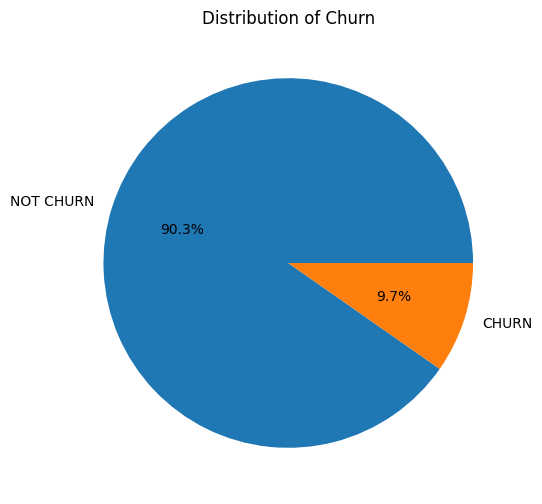

In [114]:
plt.figure(figsize=(6, 6))
plt.pie(client['churn'].value_counts(),labels=['NOT CHURN','CHURN'],autopct='%1.1f%%')
plt.title('Distribution of Churn')
plt.show()

**Channel Sales :**

Presence of Missing Values:  
   - A category labeled **"MISSING"** appears in the dataset, indicating that missing values have been replaced with this placeholder.

In [115]:
client['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [116]:
counts = client['channel_sales'].value_counts()
client['channel_sales'] = client['channel_sales'].apply(lambda x: x if counts[x] >= 20 else 'RARE')

- RARE represents only 0.11% of the dataset ‚Üí extremely small portion ‚Üí statistically negligible.

- RARE has a churn rate of 0.0% ‚Üí no churn at all ‚Üí no risk or special behavior detected.

- The global churn rate is 9.7% ‚Üí meaning RARE is not only low-risk but also artificially lowers the variability in the dataset.

- Keeping RARE adds no value to the model or analysis, and could even introduce noise or bias in statistical tests like Chi¬≤.

In [117]:
rare_count = client[client['channel_sales'] == 'RARE'].shape[0]
total_count = client.shape[0]
rare_percentage = rare_count / total_count * 100
print(f"RARE repr√©sente {rare_percentage:.2f}% des donn√©es")

RARE repr√©sente 0.11% des donn√©es


In [118]:
rare_churn = client[client['channel_sales'] == 'RARE']['churn'].mean()
global_churn = client['churn'].mean()

print("Taux de churn RARE:", rare_churn)
print("Taux de churn global:", global_churn)

Taux de churn RARE: 0.0
Taux de churn global: 0.09715185540188963


In [119]:
client = client[client['channel_sales'] != 'RARE']

In [120]:
client['date_activ'] = pd.to_datetime(client['date_activ'])

<ipython-input-120-dce2c5349443>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client['date_activ'] = pd.to_datetime(client['date_activ'])


In [121]:
client['year_activation'] = client['date_activ'].dt.year
client['channel_sales_group'] = client['channel_sales'].apply(lambda x: x if x != 'MISSING' else 'MISSING')

<ipython-input-121-1449fb2d027f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client['year_activation'] = client['date_activ'].dt.year
<ipython-input-121-1449fb2d027f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client['channel_sales_group'] = client['channel_sales'].apply(lambda x: x if x != 'MISSING' else 'MISSING')


In [122]:
client['channel_sales_group'] = client.groupby('year_activation')['channel_sales'].transform(lambda x: x.value_counts().idxmax())

<ipython-input-122-b501349d4d29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client['channel_sales_group'] = client.groupby('year_activation')['channel_sales'].transform(lambda x: x.value_counts().idxmax())


In [123]:
client['ERA'] = pd.cut(client['year_activation'],
                       bins=[2000, 2005, 2010, 2015],
                       labels=['2000-2005', '2006-2010', '2011-2015'])

era_channel_crosstab = pd.crosstab(client['ERA'], client['channel_sales_group'], normalize='index')

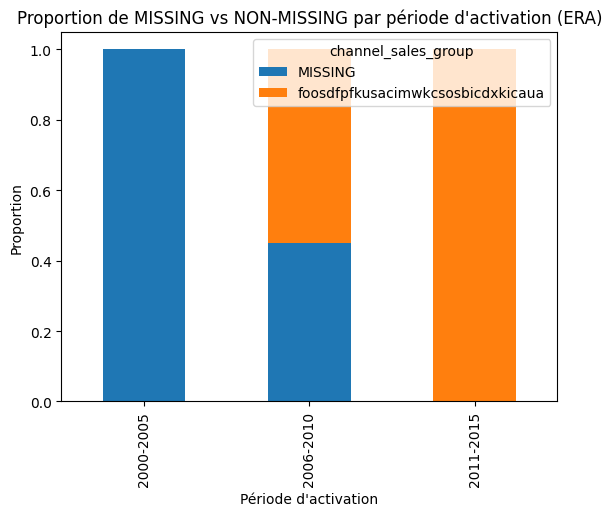

In [124]:
era_channel_crosstab.plot(kind='bar', stacked=True)
plt.title("Proportion de MISSING vs NON-MISSING par p√©riode d'activation (ERA)")
plt.xlabel("P√©riode d'activation")
plt.ylabel("Proportion")
plt.show()

In [125]:
client['channel_sales'] = client['channel_sales'].replace({'MISSING': 'LEGACY_CLIENT'})

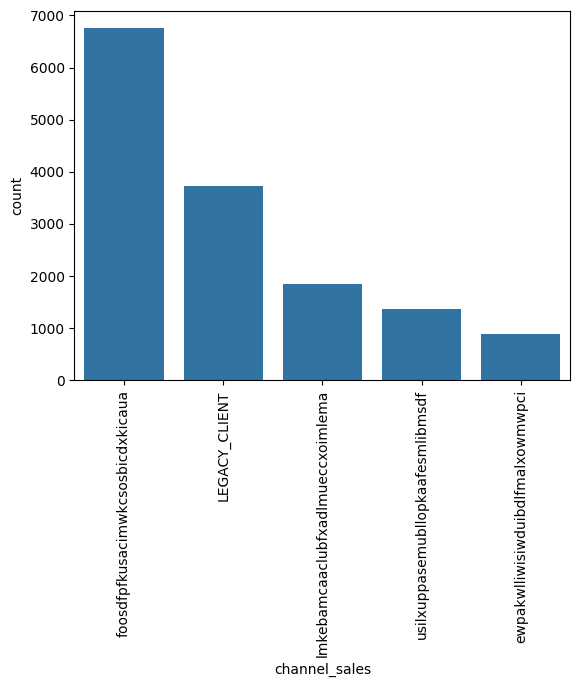

In [126]:
sns.countplot(x='channel_sales', data=client)
plt.xticks(rotation=90)
plt.show()

**has_gas :**
   - The largest portion of customers (81.8%) have a gas subscription.  
   - This suggests that gas services are highly adopted among clients.


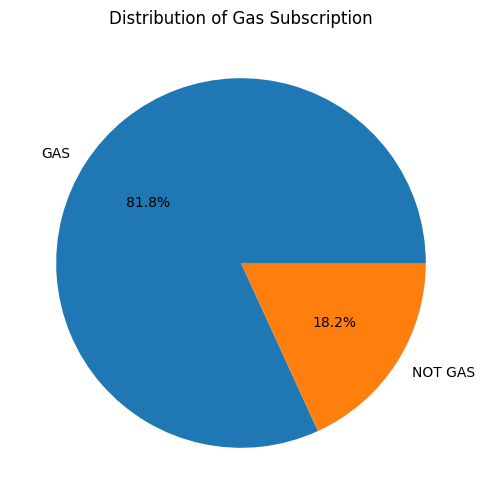

In [127]:
plt.figure(figsize=(6, 6))
plt.pie(client['has_gas'].value_counts(),labels=['GAS','NOT GAS'],autopct='%1.1f%%')
plt.title('Distribution of Gas Subscription')
plt.show()

**num_years_antig**

This suggests that most customers have been with the company for between 4 and 6 years. There are also some long-term customers who have been with the company for up to 13 years

In [128]:
client['num_years_antig'].describe()

count   14590.00
mean        5.00
std         1.61
min         1.00
25%         4.00
50%         5.00
75%         6.00
max        13.00
Name: num_years_antig, dtype: float64

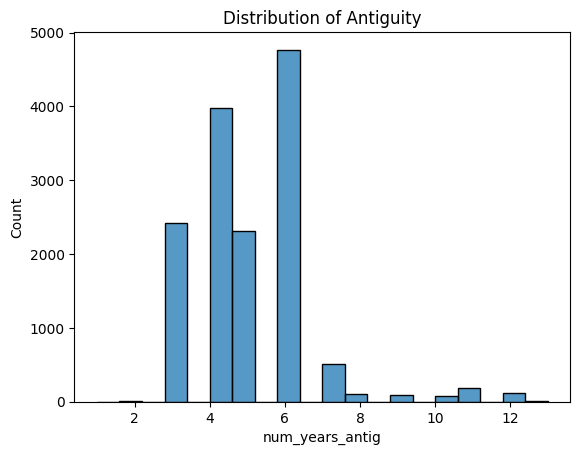

In [129]:
sns.histplot(client['num_years_antig'],bins=20)
plt.title('Distribution of Antiguity')
plt.show()

**nb_prod_act**

This suggests that most customers have 1 active product, but there are also some customers who have multiple active products, with a maximum of 32 active products



In [130]:
client['nb_prod_act'].value_counts().reset_index()

nb_prod_act  count
0            1  11416
1            2   2444
2            3    523
3            4    150
4            5     31
5            9     11
6            6      8
7            8      4
8           10      2
9           32      1

**Origin_up**

The campaign lxidpiddsbxsbosboudacockeimpuepw was the most popular among customers, followed by kamkkxfxxuwbdslkwifmmcsiusiuosws and ldkssxwpmemidmecebumciepifcamkci

**MISSING :** For 64 customers, the campaign they first subscribed to is missing

In [131]:
client['origin_up'] = client['origin_up'].apply(lambda x: x if client['origin_up'].value_counts()[x] >= 10 else 'RARE')
client['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7094
kamkkxfxxuwbdslkwifmmcsiusiuosws    4292
ldkssxwpmemidmecebumciepifcamkci    3137
MISSING                               64
RARE                                   3
Name: count, dtype: int64

- RARE represents only 0.02% of the total dataset ‚Üí statistically irrelevant in terms of volume.

- Churn rate within RARE :  0% churn no special or risky behavior.

- RARE adds no useful signal to the churn analysis, it only introduces statistical noise and bias in Chi¬≤ test.

- Keeping RARE will invalidate Chi¬≤ results due to extremely small expected frequencies.

In [132]:
rare_count = client[client['origin_up'] == 'RARE'].shape[0]
total_count = client.shape[0]
rare_percentage = rare_count / total_count * 100
print(f"RARE repr√©sente {rare_percentage:.2f}% des donn√©es")

RARE repr√©sente 0.02% des donn√©es


In [133]:
rare_churn_counts = client[client['origin_up'] == 'RARE']['churn'].value_counts(normalize=True)
print("Taux de churn chez les RARE:")
rare_churn_counts

Taux de churn chez les RARE:


churn
0   1.00
Name: proportion, dtype: float64

In [134]:
client = client[client['origin_up'] != 'RARE']
client = client[client['origin_up'] != 'MISSING']

**cons_12m**

- Residential: ‚â§ 40,000 kWh/year (aligned with your 75th percentile)

- Small Businesses: 40k‚Äì500k kWh/year

- Industrial/Large Consumers: ‚â• 500k kWh/year (may represent 80% of total consumption despite being 0.1% of customers)


In [135]:
pd.set_option('display.float_format', '{:.2f}'.format)
client['cons_12m'].describe()

count     14523.00
mean     159621.18
std      574498.36
min           0.00
25%        5675.50
50%       14118.00
75%       40768.50
max     6207104.00
Name: cons_12m, dtype: float64

**cons_gas_12m**

The columns shows highly skewed gas consumption, with 75% of customers having zero gas

In [136]:
client['cons_gas_12m'].describe()

count     14523.00
mean      28178.60
std      163374.84
min           0.00
25%           0.00
50%           0.00
75%           0.00
max     4154590.00
Name: cons_gas_12m, dtype: float64

**cons_last_month**

At least **25%** customers did not consume electricity last month

High Variability in Consumption (Std = 64,364.2)

Consumption varies widely, meaning customer behavior is unpredictable.

Some factors influencing this could be :

  - Industry differences (residential vs. industrial customers).

  - Seasonal demand (e.g., higher usage in summer or winter).



In [137]:
client['cons_last_month'].describe()

count    14523.00
mean     16128.21
std      64479.04
min          0.00
25%          0.00
50%        794.00
75%       3383.00
max     771203.00
Name: cons_last_month, dtype: float64

## **Multivariate Analysis : Client Dataset**

**channel_sales vs churn**

üîπ foosdfpfkusacimwkcsosbicdxkicaua

  - Largest sales channel with 6,754 clients.

  - 820 clients churned, resulting in a churn rate of 12.1%.

  - High churn volume and high churn rate ‚Äî requires in-depth analysis.

üîπ MISSING

  - Represents clients with an undefined or missing sales channel.

  - 3,725 clients total, with 283 churned.

  - Churn rate of 7.6% ‚Äî could indicate data quality issues or hidden patterns.

üîπ usilxuppasemubllopkaafesmlibmsdf

  - Medium-sized channel with 1,375 clients.

  - Churn rate of 10.0% ‚Äî relatively high, possibly problematic channel.

üîπ lmkebamcaaclubfxadlmueccxoimlema

   - 1,843 clients total, 103 churned.

   - Churn rate of 5.6% ‚Äî lower risk compared to others.

üîπ ewpakwlliwisiwduibdlfmalxowmwpci

   - 893 clients, 75 churned.

   - Churn rate of 8.4% ‚Äî moderate churn level, worth monitoring.

üîπ Minor channels with no churn:

  - sddiedcslfslkckwlfkdpoeeailfpeds ‚Äî 11 clients.

  - epumfxlbckeskwekxbiuasklxalciiuu ‚Äî 3 clients.

  - fixdbufsefwooaasfcxdxadsiekoceaa ‚Äî 2 clients.

  - All have 0% churn, but due to very low volume, their impact is minimal.


| channel_sales                           | has_churn | not_churn | total_clients | churn_rate (%) |
|-----------------------------------------|-----------|-----------|----------------|----------------|
| `foosdfpfkusacimwkcsosbicdxkicaua`      |    820    |   5934    |      6754      |     12.1%      |
| `MISSING`                               |    283    |   3442    |      3725      |     7.6%       |
| `usilxuppasemubllopkaafesmlibmsdf`      |    138    |   1237    |      1375      |     10.0%      |
| `lmkebamcaaclubfxadlmueccxoimlema`      |    103    |   1740    |      1843      |     5.6%       |
| `ewpakwlliwisiwduibdlfmalxowmwpci`      |     75    |    818    |       893      |     8.4%       |
| `sddiedcslfslkckwlfkdpoeeailfpeds`      |      0    |     11    |        11      |     0.0%       |
| `epumfxlbckeskwekxbiuasklxalciiuu`      |      0    |      3    |         3      |     0.0%       |
| `fixdbufsefwooaasfcxdxadsiekoceaa`      |      0    |      2    |         2      |     0.0%       |



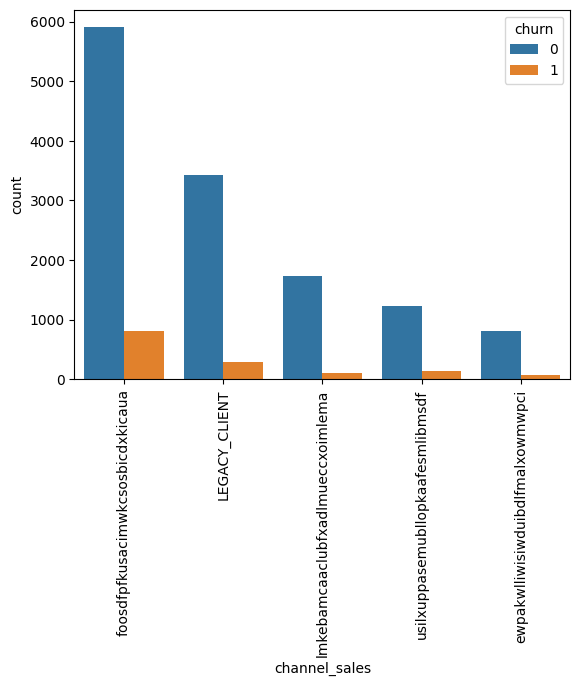

In [138]:
sns.countplot(data=client, x="channel_sales", hue="churn")
plt.xticks(rotation=90)
plt.show()

**has_gas vs churn**


Clients without gas subscription (has_gas = f):

  - Churn rate = 10%

  - These clients are slightly more likely to churn.

Clients with gas subscription (has_gas = t):

  - Churn rate = 8%

  - These clients show a lower churn rate, which may indicate greater loyalty or satisfaction due to bundled energy services.



In [139]:
client.groupby('has_gas')['churn'].mean().reset_index()

has_gas  churn
0       f   0.10
1       t   0.08

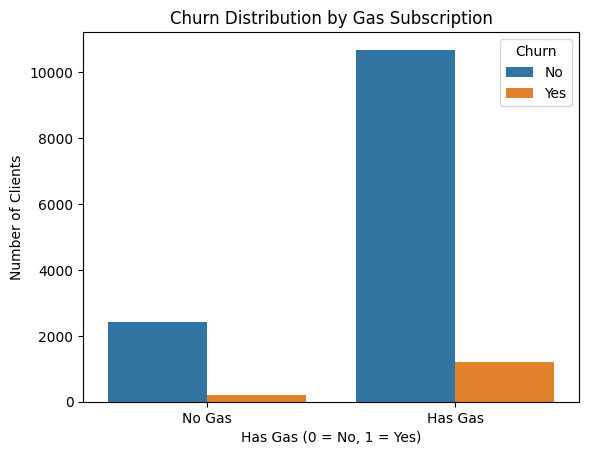

In [140]:
sns.countplot(data=client, x='has_gas', hue='churn')
plt.title("Churn Distribution by Gas Subscription")
plt.xlabel("Has Gas (0 = No, 1 = Yes)")
plt.ylabel("Number of Clients")
plt.xticks([0, 1], ["No Gas", "Has Gas"])
plt.legend(title="Churn", labels=["No", "Yes"])
plt.show()

**num_years_antig vs churn**

- New customers (Year¬†1) leave the most‚Äîabout 27% churn.

- After the first year, churn drops quickly (down to around 9% by Year¬†4).

- From Years¬†5‚Äì7, churn stays low (7‚Äì8%).

- At Year¬†8 it hits a very low point (about 1%), but that may just be because there aren‚Äôt many customers that old.

- After Year¬†8, churn ticks up a bit (around 5‚Äì6%) and even spikes at Year¬†12 (about 10%), again likely due to very small groups where a few people leave makes the rate jump

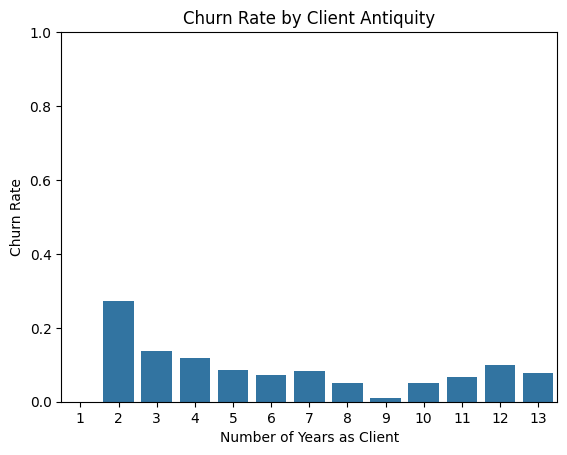

In [141]:
churn_rate = client.groupby('num_years_antig')['churn'].mean().reset_index()
sns.barplot(data=churn_rate, x='num_years_antig', y='churn')
plt.title("Churn Rate by Client Antiquity")
plt.xlabel("Number of Years as Client")
plt.ylabel("Churn Rate")
plt.ylim(0, 1)
plt.show()

**origin_up vs churn**

 - lxidpiddsbxsbosboudacockeimpuepw has the highest churn (~12.5%)
 - ldkssxwpmemidmecebumciepifcamkci has around 8.5% churn
 - These are customers with no known source
 - kamkkxfxxuwbdslkwifmmcsiusiuosws and ewxeelcelemmiwuafmddpobolfuxioce have around 6% churn
 - usapbepcfoloekilkwsdiboslwaxobdp has 0% churn


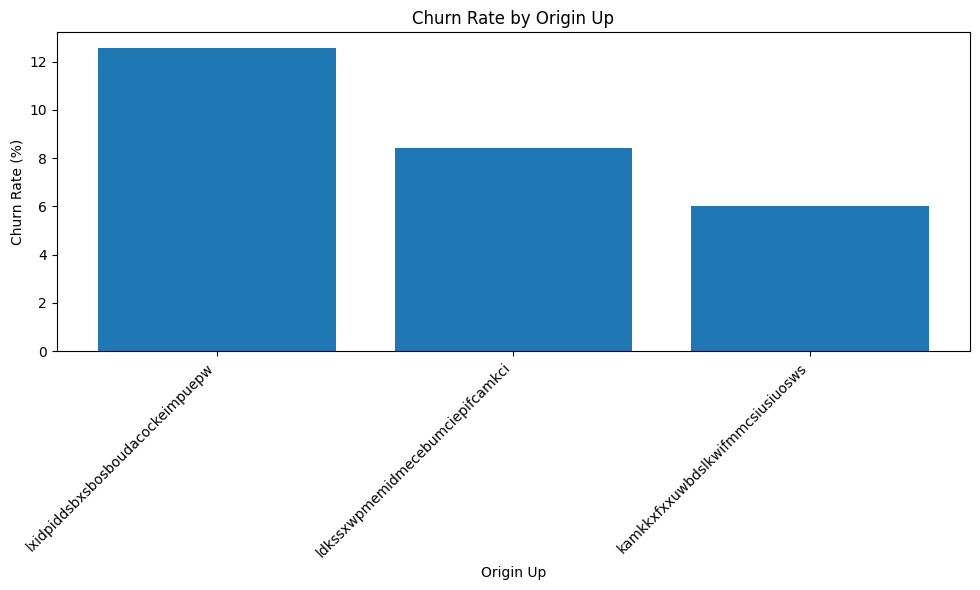

In [142]:
df = client.groupby('origin_up')['churn'].mean().sort_values(ascending=False).reset_index()
df['churn_pct'] = df['churn'] * 100
plt.figure(figsize=(10, 6))
plt.bar(df['origin_up'], df['churn_pct'])
plt.xlabel('Origin Up')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Origin Up')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**nb_prod_act vs churn**

- Most clients who churn have only 1 active product.

- As the number of active products increases, churn drops significantly.

- Churn is rare or almost zero when a client has 4 or more products

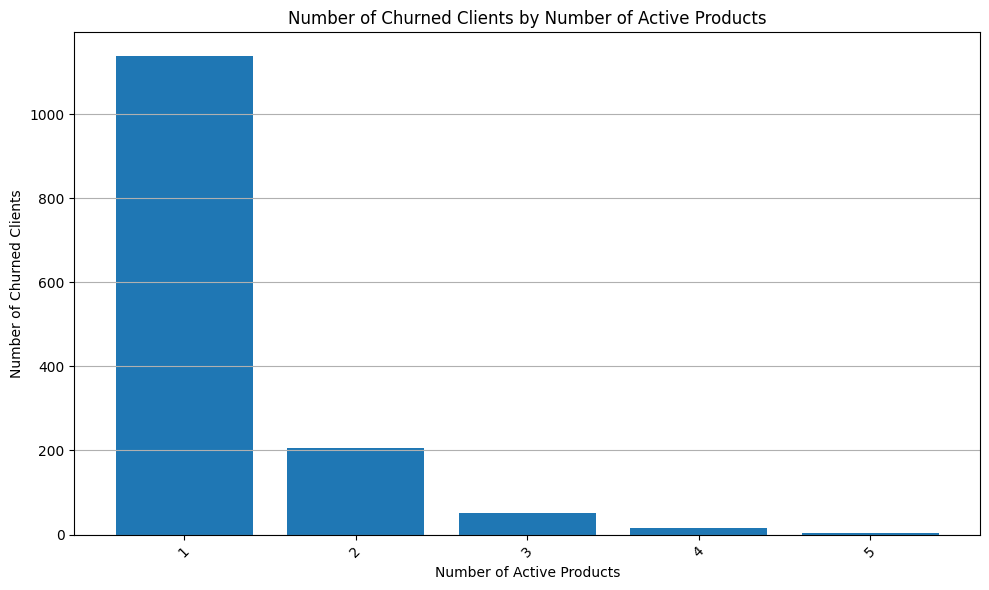

In [143]:
df_churn = client[client['churn'] == 1]
result_churn = df_churn.groupby('nb_prod_act')[['churn']].count().rename(columns={'churn': 'churn_count'}).reset_index()
plt.figure(figsize=(10, 6))
plt.bar(result_churn['nb_prod_act'].astype(str), result_churn['churn_count'])
plt.title('Number of Churned Clients by Number of Active Products')
plt.xlabel('Number of Active Products')
plt.ylabel('Number of Churned Clients')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**cons_12m vs churn**

- Customers who did not churn consume more than twice as much electricity on average compared to those who did churn.

- This suggests a negative relationship: the lower the consumption, the higher the chance of churn

In [144]:
moyennes = client.groupby('churn')['cons_12m'].mean()

print("Consommation moyenne (en kWh) selon churn :")
print(f"- Clients NON churn√©s (churn = 0) : {moyennes[0]:,.2f} kWh")
print(f"- Clients churn√©s (churn = 1)     : {moyennes[1]:,.2f} kWh")

Consommation moyenne (en kWh) selon churn :
- Clients NON churn√©s (churn = 0) : 168,325.32 kWh
- Clients churn√©s (churn = 1)     : 78,989.55 kWh


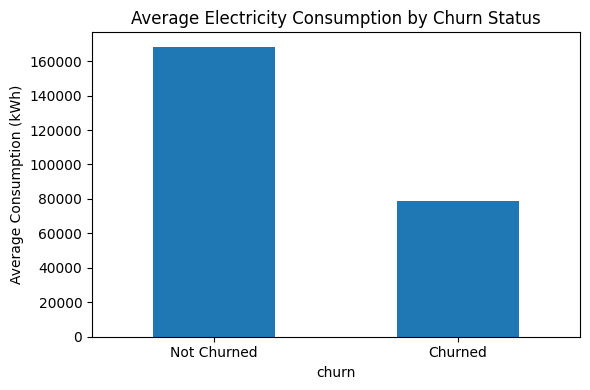

In [145]:
avg_consumption = client.groupby('churn')['cons_12m'].mean()

plt.figure(figsize=(6, 4))
avg_consumption.plot(kind='bar')

plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.ylabel('Average Consumption (kWh)')
plt.title('Average Electricity Consumption by Churn Status')
plt.tight_layout()
plt.show()

**cons_gas_12m vs churn**

- Customers who did not churn consume more than twice as much gas on average compared to those who did churn.

- This suggests a negative relationship: the lower the consumption, the higher the chance of churn

In [146]:
avg_gas = client.groupby('churn')['cons_gas_12m'].mean()

print("Average gas consumption over 12 months:")
print(f"- Not churned (0): {avg_gas[0]:,.2f} kWh")
print(f"- Churned (1): {avg_gas[1]:,.2f} kWh")

Average gas consumption over 12 months:
- Not churned (0): 30,221.25 kWh
- Churned (1): 9,256.28 kWh


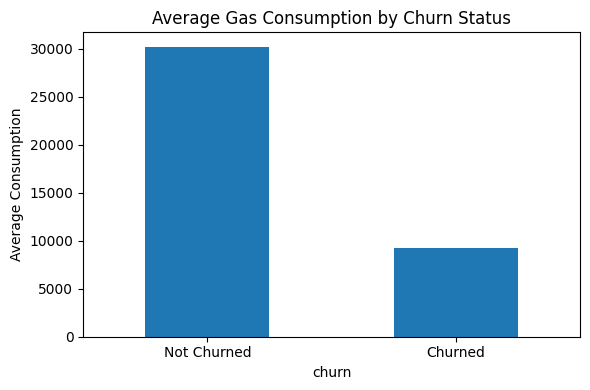

In [147]:
avg_consumption = client.groupby('churn')['cons_gas_12m'].mean()

plt.figure(figsize=(6, 4))
avg_consumption.plot(kind='bar')

plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.ylabel('Average Consumption')
plt.title('Average Gas Consumption by Churn Status')
plt.tight_layout()
plt.show()

**cons_last_month vs churn**

 - Clients who did not churn consumed much more electricity during the last month.

 - Clients who churned had lower average consumption.

In [148]:
moyennes = client.groupby('churn')['cons_last_month'].mean()
print(f"Not churned (0): {moyennes[0]:,.2f} kWh")
print(f"Churned     (1): {moyennes[1]:,.2f} kWh")

Not churned (0): 17,090.26 kWh
Churned     (1): 7,216.08 kWh


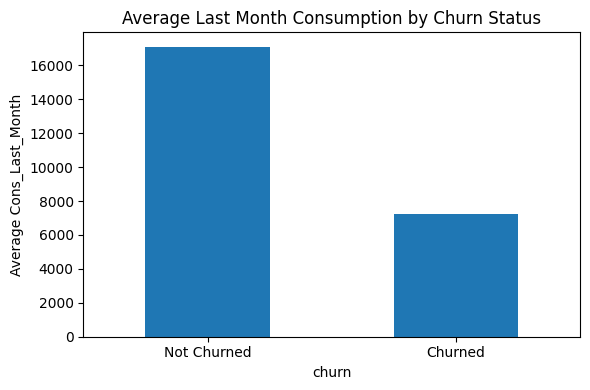

In [149]:
avg_consumption = client.groupby('churn')['cons_last_month'].mean()

plt.figure(figsize=(6, 4))
avg_consumption.plot(kind='bar')

plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.ylabel('Average Cons_Last_Month')
plt.title('Average Last Month Consumption by Churn Status')
plt.tight_layout()
plt.show()

**margin_gross_pow_ele, margin_net_pow_ele, net_margin vs churn**

- We usually expect low-margin clients to churn, but here, profitable clients are the ones leaving

- net_margin shows the largest gap, suggesting it may be more closely related to churn than the others

In [150]:
margins = ['net_margin', 'margin_net_pow_ele', 'margin_gross_pow_ele']

for col in margins:
    avg = client.groupby('churn')[col].mean()
    print(f"{col} ‚Üí Not churned: {avg[0]:,.2f} | Churned: {avg[1]:,.2f}")


net_margin ‚Üí Not churned: 184.66 | Churned: 228.17
margin_net_pow_ele ‚Üí Not churned: 23.90 | Churned: 30.46
margin_gross_pow_ele ‚Üí Not churned: 23.91 | Churned: 30.46


**date_activ,date_end,date_modif_prod,date_renewal vs churn**

In [151]:
client['date_activ'] = pd.to_datetime(client['date_activ'])
client['date_end'] = pd.to_datetime(client['date_end'])
client['date_modif_prod'] = pd.to_datetime(client['date_modif_prod'])
client['date_renewal'] = pd.to_datetime(client['date_renewal'])

**duration_contract** : Customers with longer contracts are less likely to churn

In [152]:
client['duration_contract'] = (client['date_end'] - client['date_activ']).dt.days

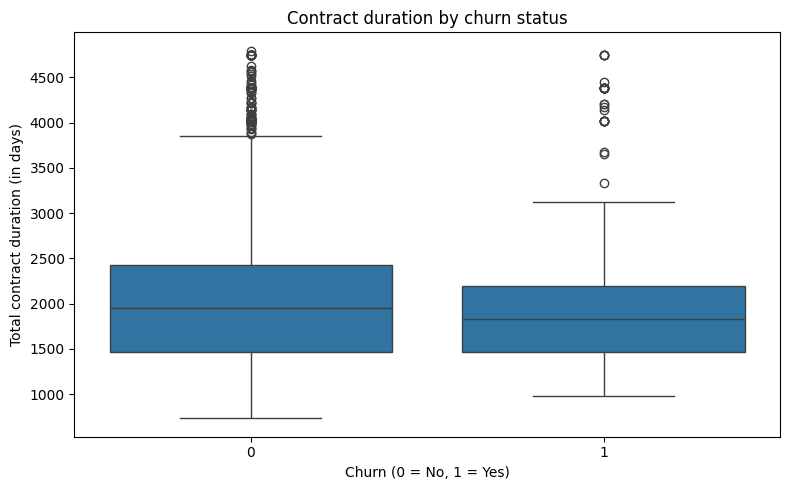

In [153]:

plt.figure(figsize=(8, 5))
sns.boxplot(x='churn', y='duration_contract', data=client)
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Total contract duration (in days)')
plt.title('Contract duration by churn status')
plt.tight_layout()
plt.show()

**time_before_modification :**
- Early modifications in the contract are more associated with churn.

- Clients who stick longer without changing their plan tend to stay.

In [154]:
client['time_before_modification'] = (client['date_modif_prod'] - client['date_activ']).dt.days

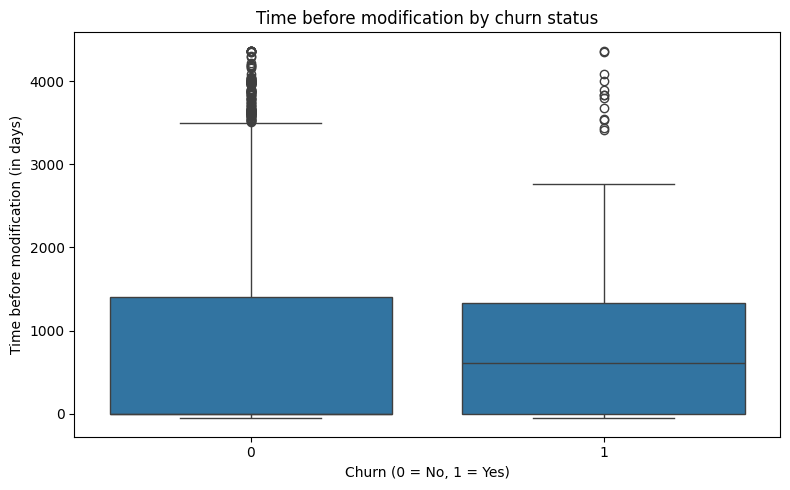

In [155]:
plt.figure(figsize=(8,5))
sns.boxplot(x='churn', y='time_before_modification', data=client)
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Time before modification (in days)')
plt.title('Time before modification by churn status')
plt.tight_layout()
plt.show()

**time_after_modification :**

A long time after modification = the client is likely to stay.

A short time after modification = the client is more likely to churn.

In [156]:
client['time_after_modification'] = client['date_end'] - client['date_modif_prod']

In [157]:
client[['time_after_modification','churn']].groupby('churn').agg(['mean','median','min','max'])

time_after_modification                            
                              mean    median     min       max
churn                                                         
0     1320 days 06:43:23.600854448 1096 days 30 days 4749 days
1     1153 days 08:09:29.893992928  949 days 43 days 4749 days

**margin_gross_pow_ele, margin_net_pow_ele, net_margin vs churn**

- Churners generate a higher gross margin on average
- Churners have higher margins even after costs
- Some churners are very high-value clients

In [158]:
client.groupby('churn')[['margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin']].agg(['mean', 'median', 'min', 'max'])

margin_gross_pow_ele                    margin_net_pow_ele              \
                      mean median  min    max               mean median  min   
churn                                                                          
0                    23.91  21.48 0.00 374.64              23.90  21.48 0.00   
1                    30.46  26.04 0.00 299.64              30.46  26.04 0.00   

             net_margin                       
         max       mean median  min      max  
churn                                         
0     374.64     184.66 111.81 0.00 10203.50  
1     299.64     228.17 121.86 0.00 24570.65


**forecast_cons_12m, forecast_cons_year vs churn**

- Consumption forecasts alone show small differences between churners and non-churners.

- Extreme consumers (very high forecast) are more loyal.

- Forecast alone will probably not strongly predict churn.

In [159]:
client.groupby('churn')[['forecast_cons_12m', 'forecast_cons_year']].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

forecast_cons_12m                                       \
                   mean  median     std  min      max  count   
churn                                                          
0               1854.32 1107.13 2310.73 0.00 82902.83  13108   
1               1959.82 1152.35 2755.95 0.00 61357.17   1415   

      forecast_cons_year                                    
                    mean median     std min     max  count  
churn                                                       
0                1397.78 313.00 3274.14   0  175375  13108  
1                1369.73 322.00 2690.05   0   37891   1415


**forecast_meter_rent_12m vs churn**

- Clients with high costs (high rent charges) might churn because of the cost pressure (not because they use less, but because they find it too expensive)

- The rent price could be perceived as too high, making them leave even if they are active clients

- Big variability in forecasted rents, meaning many different client profiles

- **high rent cost = dissatisfaction = churn**

In [160]:
client.groupby('churn')['forecast_meter_rent_12m'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

mean  median   std  min    max  count
churn                                       
0     62.13   18.66 65.52 0.00 599.31  13108
1     72.00   19.97 70.83 0.00 548.41   1415

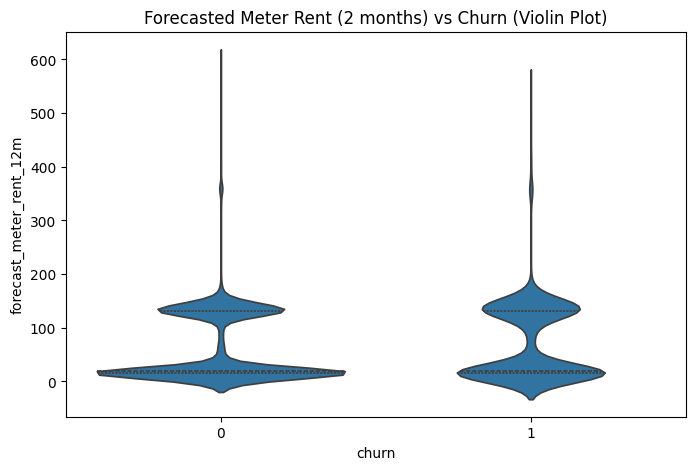

In [161]:
plt.figure(figsize=(8,5))
sns.violinplot(x='churn', y='forecast_meter_rent_12m', data=client, inner='quartile')
plt.title('Forecasted Meter Rent (2 months) vs Churn (Violin Plot)')
plt.show()

##**Price Data Analysis**

In [162]:
client.head(2)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                     LEGACY_CLIENT   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   

  date_modif_prod date_renewal  forecast_cons_12m  ...  num_years_antig  \
0      2015-11-01   2015-06-23               0.00  ...                3   
1      2009-08-21   2015-08-31             189.95  ...                6   

                          origin_up  pow_max  churn  year_activation  \
0  lxidpiddsbxsbosboudacockeimpuepw    43.65      1             2013   
1  kamkkxfxxuwbdslkwifmmcsiusiuosws    13.80      0             2009   

                channel_sales_group        ERA  duration_contract  \
0  foosdfpfkusacimwkcsosbicdxkicaua  2011-2015               1096   
1                           MISSING  2006-2010               2566   

   time_before_modification  time_after_modification  
0                       869                 227 days  
1                         0                2566 days  

[2 rows x 32 columns]

In [163]:
price[price['id'] == 'd29c2c54acc38ff3c0614d0a653813dd']

id  price_date  price_off_peak_var  \
169421  d29c2c54acc38ff3c0614d0a653813dd  2015-01-01                0.15   
169422  d29c2c54acc38ff3c0614d0a653813dd  2015-02-01                0.15   
169423  d29c2c54acc38ff3c0614d0a653813dd  2015-03-01                0.15   
169424  d29c2c54acc38ff3c0614d0a653813dd  2015-04-01                0.15   
169425  d29c2c54acc38ff3c0614d0a653813dd  2015-05-01                0.15   
169426  d29c2c54acc38ff3c0614d0a653813dd  2015-06-01                0.15   
169427  d29c2c54acc38ff3c0614d0a653813dd  2015-07-01                0.15   
169428  d29c2c54acc38ff3c0614d0a653813dd  2015-08-01                0.15   
169429  d29c2c54acc38ff3c0614d0a653813dd  2015-09-01                0.15   
169430  d29c2c54acc38ff3c0614d0a653813dd  2015-10-01                0.15   
169431  d29c2c54acc38ff3c0614d0a653813dd  2015-11-01                0.15   
169432  d29c2c54acc38ff3c0614d0a653813dd  2015-12-01                0.15   

        price_peak_var  price_mid_peak_var  price_off_peak_fix  \
169421            0.00                0.00               44.27   
169422            0.00                0.00               44.27   
169423            0.00                0.00               44.27   
169424            0.00                0.00               44.27   
169425            0.00                0.00               44.27   
169426            0.00                0.00               44.27   
169427            0.00                0.00               44.27   
169428            0.00                0.00               44.27   
169429            0.09                0.00               44.27   
169430            0.00                0.00               44.44   
169431            0.00                0.00               44.44   
169432            0.00                0.00               44.44   

        price_peak_fix  price_mid_peak_fix  
169421            0.00                0.00  
169422            0.00                0.00  
169423            0.00                0.00  
169424            0.00                0.00  
169425            0.00                0.00  
169426            0.00                0.00  
169427            0.00                0.00  
169428            0.00                0.00  
169429            0.00                0.00  
169430            0.00                0.00  
169431            0.00                0.00  
169432            0.00                0.00

In [164]:
client

id                     channel_sales  \
0      24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1      d29c2c54acc38ff3c0614d0a653813dd                     LEGACY_CLIENT   
2      764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3      bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4      149d57cf92fc41cf94415803a877cb4b                     LEGACY_CLIENT   
...                                 ...                               ...   
14601  18463073fb097fc0ac5d3e040f356987  foosdfpfkusacimwkcsosbicdxkicaua   
14602  d0a6f71671571ed83b2645d23af6de00  foosdfpfkusacimwkcsosbicdxkicaua   
14603  10e6828ddd62cbcf687cb74928c4c2d2  foosdfpfkusacimwkcsosbicdxkicaua   
14604  1cf20fd6206d7678d5bcafd28c53b4db  foosdfpfkusacimwkcsosbicdxkicaua   
14605  563dde550fd624d7352f3de77c0cdfcd                     LEGACY_CLIENT   

       cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0             0         54946                0 2013-06-15 2016-06-15   
1          4660             0                0 2009-08-21 2016-08-30   
2           544             0                0 2010-04-16 2016-04-16   
3          1584             0                0 2010-03-30 2016-03-30   
4          4425             0              526 2010-01-13 2016-03-07   
...         ...           ...              ...        ...        ...   
14601     32270         47940                0 2012-05-24 2016-05-08   
14602      7223             0              181 2012-08-27 2016-08-27   
14603      1844             0              179 2012-02-08 2016-02-07   
14604       131             0                0 2012-08-30 2016-08-30   
14605      8730             0                0 2009-12-18 2016-12-17   

      date_modif_prod date_renewal  forecast_cons_12m  ...  num_years_antig  \
0          2015-11-01   2015-06-23               0.00  ...                3   
1          2009-08-21   2015-08-31             189.95  ...                6   
2          2010-04-16   2015-04-17              47.96  ...                6   
3          2010-03-30   2015-03-31             240.04  ...                6   
4          2010-01-13   2015-03-09             445.75  ...                6   
...               ...          ...                ...  ...              ...   
14601      2015-05-08   2014-05-26            4648.01  ...                4   
14602      2012-08-27   2015-08-28             631.69  ...                3   
14603      2012-02-08   2015-02-09             190.39  ...                4   
14604      2012-08-30   2015-08-31              19.34  ...                3   
14605      2009-12-18   2015-12-21             762.41  ...                6   

                              origin_up  pow_max  churn  year_activation  \
0      lxidpiddsbxsbosboudacockeimpuepw    43.65      1             2013   
1      kamkkxfxxuwbdslkwifmmcsiusiuosws    13.80      0             2009   
2      kamkkxfxxuwbdslkwifmmcsiusiuosws    13.86      0             2010   
3      kamkkxfxxuwbdslkwifmmcsiusiuosws    13.20      0             2010   
4      kamkkxfxxuwbdslkwifmmcsiusiuosws    19.80      0             2010   
...                                 ...      ...    ...              ...   
14601  lxidpiddsbxsbosboudacockeimpuepw    15.00      0             2012   
14602  lxidpiddsbxsbosboudacockeimpuepw     6.00      1             2012   
14603  lxidpiddsbxsbosboudacockeimpuepw    15.94      1             2012   
14604  lxidpiddsbxsbosboudacockeimpuepw    11.00      0             2012   
14605  ldkssxwpmemidmecebumciepifcamkci    10.39      0             2009   

                    channel_sales_group        ERA  duration_contract  \
0      foosdfpfkusacimwkcsosbicdxkicaua  2011-2015               1096   
1                               MISSING  2006-2010               2566   
2      foosdfpfkusacimwkcsosbicdxkicaua  2006-2010               2192   
3      foosdfpfkusacimwkcsosbicdxkicaua  2006-2010               2192   
4      foosdfpfkusac

**price_date :**

 - The price_date column shows that your price data covers the full year of 2015 (from January 1st to December 1st)

In [165]:
price['price_date'].describe()

count         193002
unique            12
top       2015-12-01
freq           16094
Name: price_date, dtype: object

 99.3% of clients (15,990 out of 16,096) have a full 12 months of price data

In [166]:
coverage = price.groupby('id')['price_date'].nunique().rename('months_of_data').reset_index()
coverage['months_of_data'].value_counts().sort_index()

months_of_data
7         3
8         3
9         6
10       11
11       83
12    15990
Name: count, dtype: int64

 For each client (id), we have counted the number of times their prices changed during the year.


- Client 0002203ffbb812588b632b9e628cc38d had 2 price changes.

- Client 0010bcc39e42b3c2131ed2ce55246e3c had 3 price changes.

In [167]:
price['price_date'] = pd.to_datetime(price['price_date'])
price = price.sort_values(['id', 'price_date'])

price['any_change'] = (
    price.groupby('id')[[
        'price_off_peak_var','price_peak_var','price_mid_peak_var',
        'price_off_peak_fix','price_peak_fix','price_mid_peak_fix'
    ]]
    .diff()
    .fillna(0)
    .abs()
    .gt(0)
    .any(axis=1)
).astype(int)
change_counts = (
    price
    .groupby('id')['any_change']
    .sum()
    .rename('num_price_changes')
    .reset_index()
)
change_counts.head()

id  num_price_changes
0  0002203ffbb812588b632b9e628cc38d                  2
1  0004351ebdd665e6ee664792efc4fd13                  2
2  0010bcc39e42b3c2131ed2ce55246e3c                  3
3  0010ee3855fdea87602a5b7aba8e42de                  3
4  00114d74e963e47177db89bc70108537                  3

## **Feature Engineering**

**Why do we need to create these price features ?**

- To capture price behaviors and trends across different periods (1 year, 6 months, 3 months).

- To allow analysis of price evolution over time and link it to churn events.

- To calculate total prices per time period (variable + fixed) for better representation of what the customer actually pays.

- To prepare data for sensitivity analysis between price fluctuations and churn risk.

- To enable analysis of price volatility and its possible impact on customer loyalty or dissatisfaction.



In [168]:
price['price_date'] = pd.to_datetime(price['price_date'])

def compute_mean_price(df, date_filter=None, prefix=''):

    if date_filter:
        df = df[df['price_date'] > date_filter]

    grouped = df.groupby('id').mean().reset_index()

    rename_map = {
        "price_off_peak_var": f"{prefix}price_off_peak_var",
        "price_peak_var": f"{prefix}price_peak_var",
        "price_mid_peak_var": f"{prefix}price_mid_peak_var",
        "price_off_peak_fix": f"{prefix}price_off_peak_fix",
        "price_peak_fix": f"{prefix}price_peak_fix",
        "price_mid_peak_fix": f"{prefix}price_mid_peak_fix",
    }

    grouped = grouped.rename(columns=rename_map)

    grouped[f"{prefix}price_off_peak"] = grouped[f"{prefix}price_off_peak_var"] + grouped[f"{prefix}price_off_peak_fix"]
    grouped[f"{prefix}price_peak"] = grouped[f"{prefix}price_peak_var"] + grouped[f"{prefix}price_peak_fix"]
    grouped[f"{prefix}price_med_peak"] = grouped[f"{prefix}price_mid_peak_var"] + grouped[f"{prefix}price_mid_peak_fix"]

    return grouped


mean_year = compute_mean_price(price, None, "mean_year_")
mean_6m   = compute_mean_price(price, '2015-06-01', "mean_6m_")
mean_3m   = compute_mean_price(price, '2015-10-01', "mean_3m_")

price_features = mean_year.merge(mean_6m, on='id')
price_features = price_features.merge(mean_3m, on='id')

price_churn = price_features.merge(client[['id', 'churn']], on='id')

client = client.drop(columns=['churn']).merge(price_churn, on='id')


**Why did we create delta price features ?**

- To capture **price variations over different time periods** (3 months, 6 months, 1 year).
  
- Price changes can reflect shifts in market conditions, seasonal adjustments, or contract modifications that could affect customer satisfaction.

- Customers are likely to react to price increases or fluctuations:
  - **Short-term price increases (3m vs 6m)** ‚Üí Could trigger immediate dissatisfaction ‚Üí Potential churn risk.
  - **Mid-term price stability (6m vs 1 year)** ‚Üí Can reveal hidden patterns ‚Üí Some may tolerate slight increases, others may not.

- By calculating these deltas, we aim to:
  - Identify if **recent price changes are linked to churn behavior**.
  - Detect if customers are more sensitive to **recent vs. older price adjustments**.
  - Generate features that can be used in statistical tests or machine learning models to **better predict churn** based on price sensitivity.

- Overall, these variables help in answering the key question:
  
  > **"Are customers leaving due to recent or significant price changes ?"**

In [169]:
client["delta_3m_vs_6m_price_peak"] = client["mean_3m_price_peak"] - client["mean_6m_price_peak"]
client["delta_6m_vs_year_price_peak"] = client["mean_6m_price_peak"] - client["mean_year_price_peak"]

client["delta_3m_vs_6m_price_off_peak"] = client["mean_3m_price_off_peak"] - client["mean_6m_price_off_peak"]
client["delta_6m_vs_year_price_off_peak"] = client["mean_6m_price_off_peak"] - client["mean_year_price_off_peak"]

client["delta_3m_vs_6m_price_med_peak"] = client["mean_3m_price_med_peak"] - client["mean_6m_price_med_peak"]
client["delta_6m_vs_year_price_med_peak"] = client["mean_6m_price_med_peak"] - client["mean_year_price_med_peak"]

**ratio_cons_pow_max**

This shows if clients are over-using vs their subscribed power ‚Üí may indicate dissatisfaction or misfit ‚Üí possible churn trigger.


In [172]:
client['ratio_cons_pow_max'] = client['cons_12m'] / client['pow_max']

**flag_cross_sell**

 cross-sell often correlates with retention ‚Üí clients who consume more types of services leave less.

In [173]:
client['flag_cross_sell'] = client['nb_prod_act'] > 1

**erreur_abs_12m**

- High values indicate poor forecasting accuracy ‚Üí could be linked to customer dissatisfaction or usage anomalies ‚Üí possible churn trigger.

**ratio_gas**

-  A higher ratio may indicate customers who rely more on gas ‚Üí potential insights into customer profiles or dependencies.

**ratio_marge_cons**

- Lower values may indicate less profitability or lower value clients, which could be correlated with churn risk.

**ratio_cons_pow_max**

- If this ratio is too high, it may indicate over-usage or mismatch with subscription ‚Üí may lead to dissatisfaction ‚Üí possible churn trigger.



In [207]:
client['erreur_abs_12m'] = abs(client['cons_12m'] - client['forecast_cons_12m']) / client['forecast_cons_12m'].replace(0, np.nan)
client['ratio_gas'] = np.where(client['cons_12m'] == 0, 0, client['cons_gas_12m'] / client['cons_12m'])
client['ratio_marge_cons'] = client['net_margin'] / (client['cons_12m'] + 1e-6)
client['ratio_cons_pow_max'] = client['cons_12m'] / (client['pow_max'] + 1e-6)

#**Statistical Analysis**

In [195]:
client.columns

Index(['channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_renewal', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'channel_sales_group', 'ERA', 'duration_contract',
       'time_before_modification', 'time_after_modification',
       'mean_year_price_off_peak_var', 'mean_year_price_peak_var',
       'mean_year_price_mid_peak_var', 'mean_year_price_off_peak_fix',
       'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix',
       'mean_year_price_off_peak', 'mean_year_price_peak',
       'mean_year_price_med_peak', 'mean_6m_price_off_peak_var',
       'mean_6m_price_peak_var', 'mean_6m_price_mid_peak_var',
       'mean_6m_price_off

In [194]:
client.drop(['id','date_activ','date_modif_prod','date_end','price_date','price_date_x','price_date_y','year_activation','any_change_x','any_change_y','any_change'],axis=1,inplace=True)

##**Why Use Spearman Correlation ?**


Spearman correlation is a **non-parametric measure** of association between two variables.  

Unlike Pearson correlation, which captures **linear relationships**, Spearman focuses on **monotonic relationships** ‚Äî where variables tend to move in the same (or opposite) direction, but not necessarily at a constant rate.

**Advantages of Spearman Correlation :**

-  No assumption of normality : Pearson correlation assumes that data are normally distributed.

  In real-world datasets (prices, margins, contract durations...), this assumption is often violated.  

  **Spearman does not require normality**, making it robust for skewed or non-normal distributions.

-  Less sensitive to outliers : Because Spearman uses **rankings** instead of raw values, extreme values (outliers) have less influence on the correlation score.This makes Spearman **more robust** in datasets where anomalies or heavy tails are present.

**Why do we use Spearman correlation in our case ?**

In our dataset, we have many **price-related variables** (e.g., off-peak, mid-peak, peak prices across multiple periods like T1, T2, semester 1, semester 2, etc.).  

Before using them for modeling churn, we need to check if some of these variables are **highly redundant** (i.e., too similar to each other).



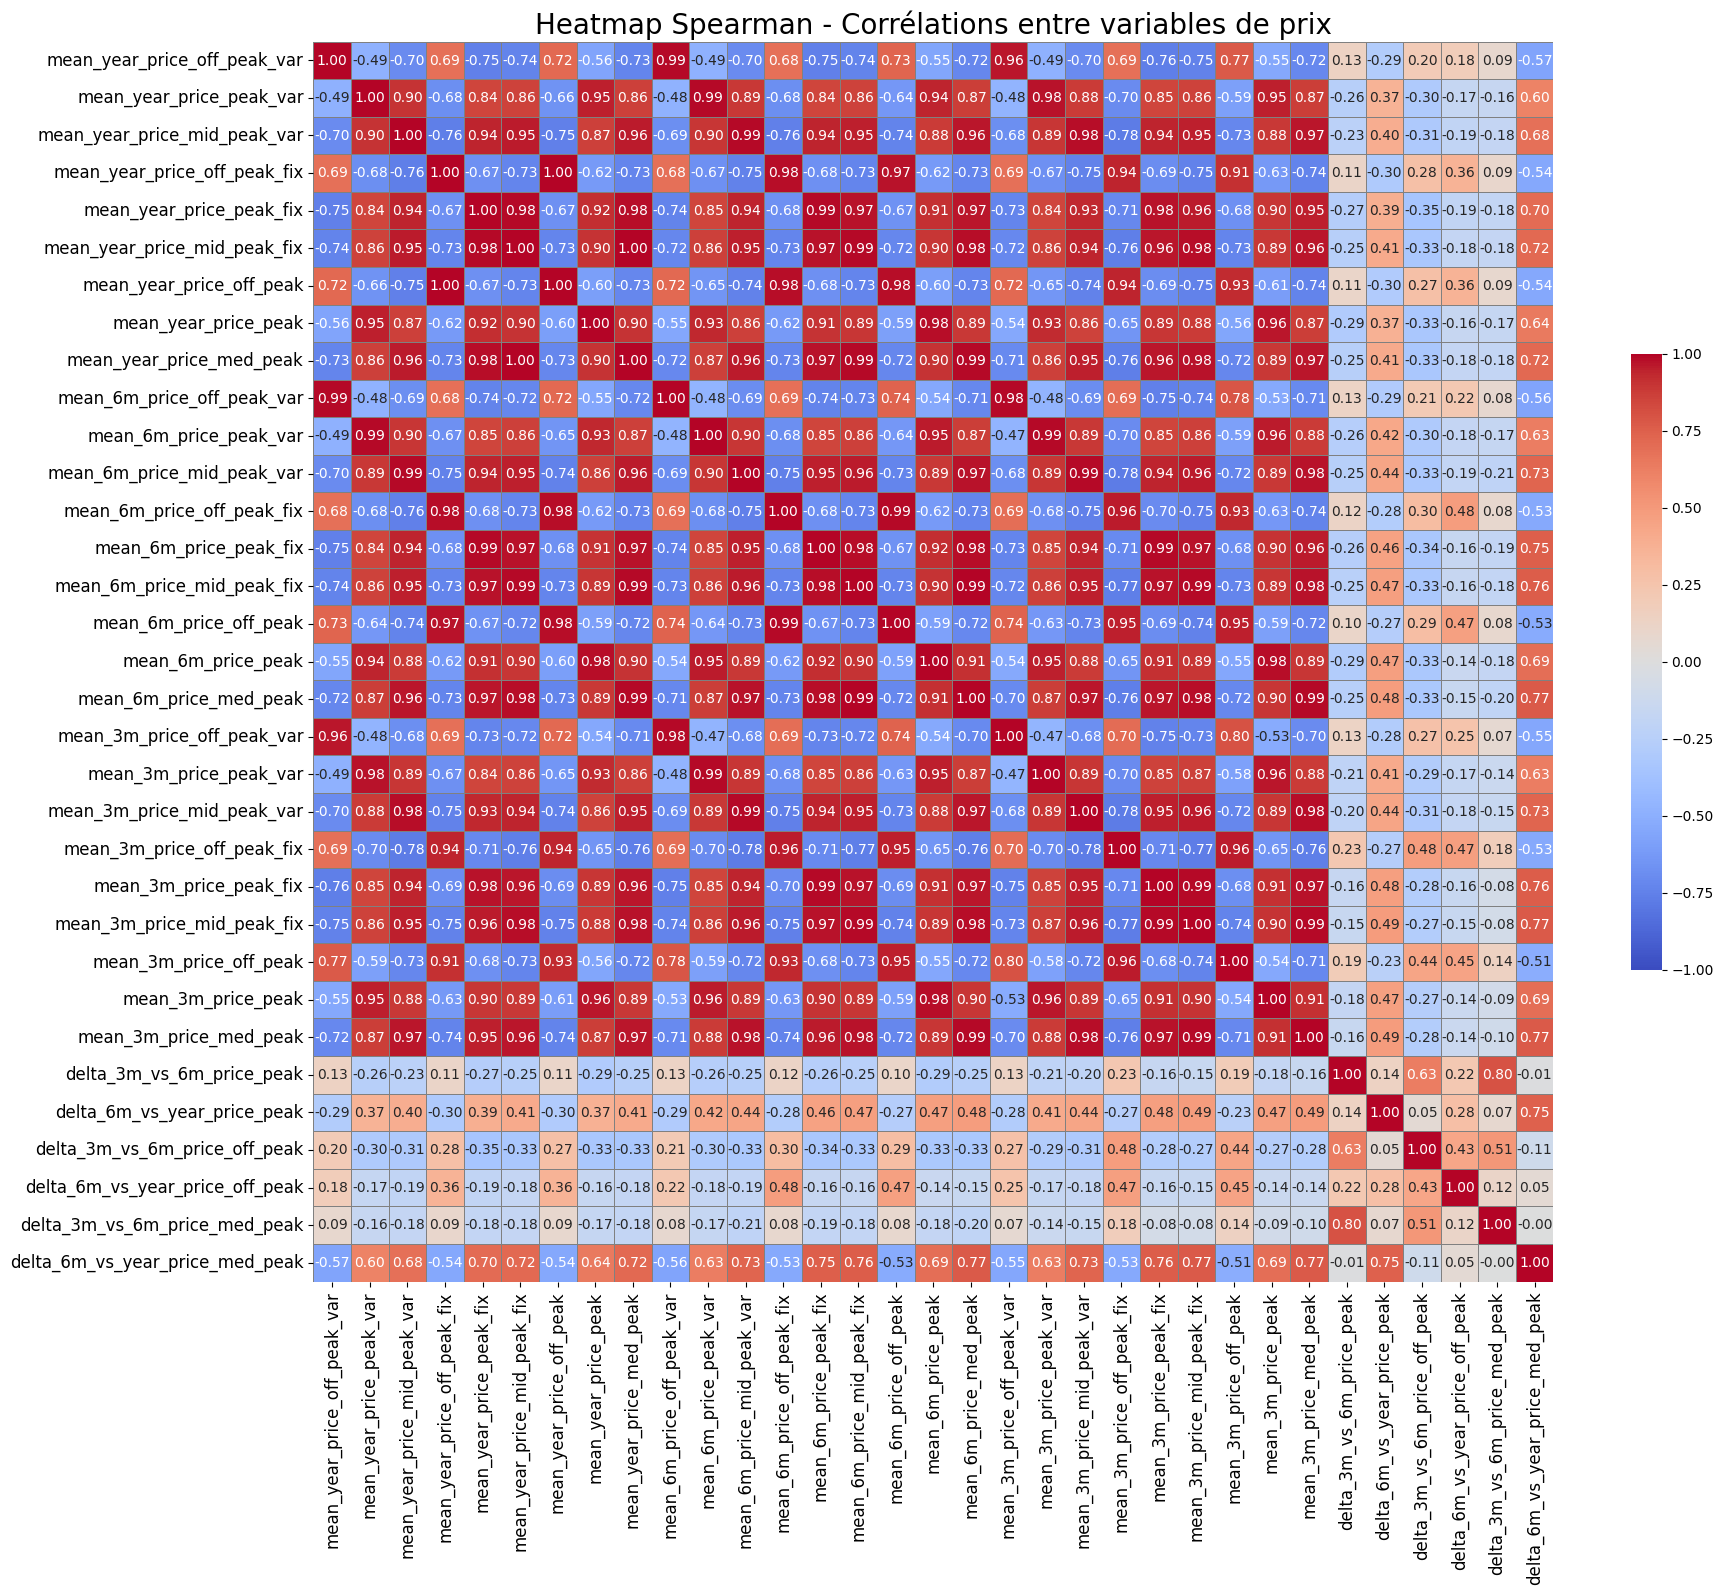

In [196]:
import seaborn as sns

price_cols = ['mean_year_price_off_peak_var', 'mean_year_price_peak_var',
       'mean_year_price_mid_peak_var', 'mean_year_price_off_peak_fix',
       'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix',
       'mean_year_price_off_peak', 'mean_year_price_peak',
       'mean_year_price_med_peak', 'mean_6m_price_off_peak_var',
       'mean_6m_price_peak_var', 'mean_6m_price_mid_peak_var',
       'mean_6m_price_off_peak_fix', 'mean_6m_price_peak_fix',
       'mean_6m_price_mid_peak_fix', 'mean_6m_price_off_peak',
       'mean_6m_price_peak', 'mean_6m_price_med_peak',
       'mean_3m_price_off_peak_var', 'mean_3m_price_peak_var',
       'mean_3m_price_mid_peak_var', 'mean_3m_price_off_peak_fix',
       'mean_3m_price_peak_fix', 'mean_3m_price_mid_peak_fix',
       'mean_3m_price_off_peak', 'mean_3m_price_peak',
       'mean_3m_price_med_peak','delta_3m_vs_6m_price_peak',
       'delta_6m_vs_year_price_peak', 'delta_3m_vs_6m_price_off_peak',
       'delta_6m_vs_year_price_off_peak', 'delta_3m_vs_6m_price_med_peak',
       'delta_6m_vs_year_price_med_peak']

df_price = client[price_cols]

corr_price = df_price.corr(method='spearman')

plt.figure(figsize=(20, 20))
sns.heatmap(corr_price,annot=True,fmt=".2f",cmap="coolwarm",vmin=-1,vmax=1,square=True,linewidths=0.5,linecolor='gray',cbar_kws={"shrink": 0.4})
plt.title("Heatmap Spearman - Corr√©lations entre variables de prix", fontsize=20)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

In [197]:
corr_matrix = df_price.corr(method='spearman').abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.7
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print("Highly redundant variables (correlation > {:.2f}) to consider dropping:\n".format(threshold))
for var in to_drop:
    print(var)

to_keep = [col for col in df_price.columns if col not in to_drop]

print("\nVariables to keep for the next steps:\n")
for var in to_keep:
    print(var)

Highly redundant variables (correlation > 0.70) to consider dropping:

mean_year_price_mid_peak_var
mean_year_price_off_peak_fix
mean_year_price_peak_fix
mean_year_price_mid_peak_fix
mean_year_price_off_peak
mean_year_price_peak
mean_year_price_med_peak
mean_6m_price_off_peak_var
mean_6m_price_peak_var
mean_6m_price_mid_peak_var
mean_6m_price_off_peak_fix
mean_6m_price_peak_fix
mean_6m_price_mid_peak_fix
mean_6m_price_off_peak
mean_6m_price_peak
mean_6m_price_med_peak
mean_3m_price_off_peak_var
mean_3m_price_peak_var
mean_3m_price_mid_peak_var
mean_3m_price_off_peak_fix
mean_3m_price_peak_fix
mean_3m_price_mid_peak_fix
mean_3m_price_off_peak
mean_3m_price_peak
mean_3m_price_med_peak
delta_3m_vs_6m_price_med_peak
delta_6m_vs_year_price_med_peak

Variables to keep for the next steps:

mean_year_price_off_peak_var
mean_year_price_peak_var
delta_3m_vs_6m_price_peak
delta_6m_vs_year_price_peak
delta_3m_vs_6m_price_off_peak
delta_6m_vs_year_price_off_peak


##**Why use the Chi-Square (Chi¬≤) Test ?**

The Chi-Square test is used to determine if there is a statistical association between two categorical variables.

In this case, we are analyzing:

- has_gas vs churn

- origin_up vs churn

- channel_sales vs churn

- ERA vs churn

- flag_cross_sell vs churn

Each of these variables is categorical, and churn is also categorical (0 = no churn, 1 = churn).

The Chi-Square test answers the question:

**Are these two categorical variables independent or related ?**

##**When to use Chi-Square Test :**

- Both variables must be categorical.

- Observations must be independent (each client counted only once).

- The expected frequency for each cell should be at least 5.

## **Steps of the Chi-Square Test :**

1. Build a contingency table.
2. Calculate expected frequencies :     
  \begin{equation}
    E(r, c) = \frac{n(r) \times c(r)}{n}
\end{equation}
   - r : row
   - c : column
   - n : corresponding total
3. Calculate the Chi-Square statistic :      
  \begin{equation}
    \chi^2_c = \sum \frac{(O_i - E_i)^2}{E_i}
\end{equation}
   - c : degree of freedom
   - O : Observed Values
   - E : Excpected Values
4. Calculate the p-value :
   The p-value depends on the Chi-Square statistic and the degrees of freedom:

     - Degrees of freedom (dof) = (number of rows - 1) * (number of columns - 1)

5. Interpret the result :

     - If p-value < 0.05 ‚Üí Reject the null hypothesis ‚Üí There is a relationship between the variables.

     - If p-value >= 0.05 ‚Üí Fail to reject ‚Üí No evidence of a relationship.






In [198]:
client.drop('channel_sales_group',inplace=True,axis=1)

In [200]:
client = client.drop([
    'mean_year_price_mid_peak_var',
    'mean_year_price_off_peak_fix',
    'mean_year_price_peak_fix',
    'mean_year_price_mid_peak_fix',
    'mean_year_price_off_peak',
    'mean_year_price_peak',
    'mean_year_price_med_peak',
    'mean_6m_price_off_peak_var',
    'mean_6m_price_peak_var',
    'mean_6m_price_mid_peak_var',
    'mean_6m_price_off_peak_fix',
    'mean_6m_price_peak_fix',
    'mean_6m_price_mid_peak_fix',
    'mean_6m_price_off_peak',
    'mean_6m_price_peak',
    'mean_6m_price_med_peak',
    'mean_3m_price_off_peak_var',
    'mean_3m_price_peak_var',
    'mean_3m_price_mid_peak_var',
    'mean_3m_price_off_peak_fix',
    'mean_3m_price_peak_fix',
    'mean_3m_price_mid_peak_fix',
    'mean_3m_price_off_peak',
    'mean_3m_price_peak',
    'mean_3m_price_med_peak',
    'delta_3m_vs_6m_price_med_peak',
    'delta_6m_vs_year_price_med_peak'
], axis=1)

In [202]:
import pandas as pd
from scipy.stats import chi2_contingency

categorical_variables = [
    'channel_sales',
    'has_gas',
    'origin_up',
    'ERA',
    'flag_cross_sell'
]

results = []

for var in categorical_variables:

    table = pd.crosstab(client[var], client['churn'])

    chi2, p, dof, expected = chi2_contingency(table)

    min_expected = expected.min()

    significant = "‚úÖ Significant" if p < 0.05 else "‚ùå Not significant"

    results.append({
        "Variable": var,
        "p-value": round(p, 5),
        "Min Expected Frequency": round(min_expected, 2),
        "Significance": significant
    })


chi2_results_df = pd.DataFrame(results)

chi2_results_df = chi2_results_df.sort_values(by="p-value")

from IPython.display import display
display(chi2_results_df)


Variable  p-value  Min Expected Frequency   Significance
0    channel_sales     0.00                   86.43  ‚úÖ Significant
2        origin_up     0.00                  305.66  ‚úÖ Significant
3              ERA     0.00                   35.37  ‚úÖ Significant
1          has_gas     0.00                  256.56  ‚úÖ Significant
4  flag_cross_sell     0.04                  307.52  ‚úÖ Significant

## **Why Use D‚ÄôAgostino and Pearson Normality Test ?**

Before applying a statistical test (such as t-test or Mann-Whitney U), it is important to know if the data follows a **normal distribution**.

- If the data is normally distributed ‚Üí we can use **parametric tests**.
- If the data is not normally distributed ‚Üí we should use **non-parametric tests**.

The **D‚ÄôAgostino and Pearson test** helps to check if the data is normally distributed by looking at:
- **Skewness** ‚Üí Is the distribution symmetrical or not?
- **Kurtosis** ‚Üí Is the distribution too peaked or too flat?

The test combines these two measures and provides a **p-value** which tells us if the distribution is normal.

**How the D‚ÄôAgostino and Pearson Test Works :**

1. Check data type
  - The test can only be applied to **numerical (continuous or ordinal) variables**.
  - Non-numeric variables are skipped.

2. Check sample size
  - The test requires at least **20 observations** to be reliable.
  - If there are too few observations ‚Üí the test is not applied.

3. Convert timedeltas if necessary
  - Timedelta variables are converted to seconds so they can be tested.

4. Run the normality test
  - The test calculates the **skewness** and **kurtosis** of the distribution.
  - It combines them into a single test statistic and calculates a **p-value**.

5. Interpret the p-value
  - If **p-value < 0.05** ‚Üí The distribution is **not normal**.
  - If **p-value >= 0.05** ‚Üí The distribution is **normal**.



In [204]:
client.drop('date_renewal',inplace=True,axis=1)

In [208]:
from scipy.stats import normaltest

variables = ['cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig','pow_max',
       'duration_contract',
       'time_before_modification', 'time_after_modification','erreur_abs_12m','ratio_gas','ratio_marge_cons','ratio_marge_cons',
'ratio_cons_pow_max',
        'mean_year_price_off_peak_var','mean_year_price_peak_var','delta_3m_vs_6m_price_peak','delta_6m_vs_year_price_peak','delta_3m_vs_6m_price_off_peak','delta_6m_vs_year_price_off_peak','ratio_cons_pow_max']

def is_numeric(series):
    return np.issubdtype(series.dtype, np.number) or np.issubdtype(series.dtype, np.timedelta64)

def has_enough_obs(series, min_n=20):
    return series.dropna().shape[0] >= min_n


results = []

for var in variables:
    g0 = client.loc[client.churn == 0, var]
    g1 = client.loc[client.churn == 1, var]

    numeric_ok = is_numeric(g0) and is_numeric(g1)
    size_ok = has_enough_obs(g0) and has_enough_obs(g1)

    if numeric_ok and np.issubdtype(g0.dtype, np.timedelta64):
        g0, g1 = g0.dt.total_seconds(), g1.dt.total_seconds()

    if numeric_ok and size_ok:
        stat0, p0 = normaltest(g0.dropna())
        stat1, p1 = normaltest(g1.dropna())
        status = "normaltest run"
    else:
        p0 = p1 = np.nan
        status = "prerequisites failed"

    results.append({
        "Variable": var,
        "dtype_ok": numeric_ok,
        "size_ok": size_ok,
        "p_value_churn_0": p0,
        "p_value_churn_1": p1,
        "Status": status
    })

df_normaltest = pd.DataFrame(results)



df_normaltest_sorted = df_normaltest.sort_values(by="p_value_churn_1")
display(df_normaltest_sorted)

df_not_normal = df_normaltest[
    (df_normaltest['p_value_churn_0'] > 0.05) | (df_normaltest['p_value_churn_1'] > 0.05)
]

display(df_not_normal)

Variable  dtype_ok  size_ok  p_value_churn_0  \
0                          cons_12m      True     True             0.00   
1                      cons_gas_12m      True     True             0.00   
2                   cons_last_month      True     True             0.00   
3                 forecast_cons_12m      True     True             0.00   
4                forecast_cons_year      True     True             0.00   
14                       net_margin      True     True             0.00   
10                         imp_cons      True     True             0.00   
8        forecast_price_energy_peak      True     True             0.00   
24               ratio_cons_pow_max      True     True             0.00   
26         mean_year_price_peak_var      True     True             0.00   
27        delta_3m_vs_6m_price_peak      True     True             0.00   
23                 ratio_marge_cons      True     True             0.00   
20                   erreur_abs_12m      True     True             0.00   
21                        ratio_gas      True     True             0.00   
22                 ratio_marge_cons      True     True             0.00   
16                          pow_max      True     True             0.00   
31               ratio_cons_pow_max      True     True             0.00   
29    delta_3m_vs_6m_price_off_peak      True     True             0.00   
28      delta_6m_vs_year_price_peak      True     True             0.00   
30  delta_6m_vs_year_price_off_peak      True     True             0.00   
5          forecast_discount_energy      True     True             0.00   
11             margin_gross_pow_ele      True     True             0.00   
12               margin_net_pow_ele      True     True             0.00   
9       forecast_price_pow_off_peak      True     True             0.00   
13                      nb_prod_act      True     True             0.00   
25     mean_year_price_off_peak_var      True     True             0.00   
7    forecast_price_energy_off_peak      True     True             0.00   
15                  num_years_antig      True     True             0.00   
17                duration_contract      True     True             0.00   
6           forecast_meter_rent_12m      True     True             0.00   
18         time_before_modification      True     True             0.00   
19          time_after_modification      True     True             0.00   

    p_value_churn_1          Status  
0              0.00  normaltest run  
1              0.00  normaltest run  
2              0.00  normaltest run  
3              0.00  normaltest run  
4              0.00  normaltest run  
14             0.00  normaltest run  
10             0.00  normaltest run  
8              0.00  normaltest run  
24             0.00  normaltest run  
26             0.00  normaltest run  
27             0.00  normaltest run  
23             0.00  normaltest run  
20             0.00  normaltest run  
21             0.00  normaltest run  
22             0.00  normaltest run  
16             0.00  normaltest run  
31             0.00  normaltest run  
29             0.00  normaltest run  
28             0.00  normaltest run  
30             0.00  normaltest run  
5              0.00  normaltest run  
11             0.00  normaltest run  
12             0.00  normaltest run  
9              0.00  normaltest run  
13             0.00  normaltest run  
25             0.00  normaltest run  
7              0.00  normaltest run  
15             0.00  normaltest run  
17             0.00  normaltest run  
6              0.00  normaltest run  
18             0.00  normaltest run  
19             0.00  normaltest run

Empty DataFrame
Columns: [Variable, dtype_ok, size_ok, p_value_churn_0, p_value_churn_1, Status]
Index: []

### Price Sensitivity Analysis

We conducted a **Mann-Whitney U Test** to analyze price variation deltas and determine if there are significant differences between churned and non-churned clients.  
The following deltas were examined:

- `delta_3m_vs_6m_price_peak`
- `delta_6m_vs_year_price_peak`
- `delta_3m_vs_6m_price_off_peak`
- `delta_6m_vs_year_price_off_peak`

Afterwards, the **Benjamini-Hochberg correction** was applied to adjust for multiple hypothesis testing.

### Corrected P-Values and Interpretation

| Delta                      | Corrected P-Value | Result                                           |
|----------------------------|-------------------|--------------------------------------------------|
| delta_3m_vs_6m_price_peak  | 0.036             | Significant difference even after correction    |
| delta_6m_vs_year_price_peak| 0.767             | NOT significant after correction (likely noise) |
| delta_3m_vs_6m_price_off_peak| 0.036           | Significant difference even after correction    |
| delta_6m_vs_year_price_off_peak| 0.116         | NOT significant after correction (likely noise) |
|mean_year_price_off_peak_var|0.0006658160141198452|Significant difference even after correction
|mean_year_price_peak_var |1.917186295203149e-05|Significant difference even after correction |

###Conclusion

- **Short-term price variations (3m vs 6m)** show statistically significant differences ‚Üí **indicating price sensitivity** and potential impact on churn.
- **Longer-term price variations (6m vs year)** do **not show significant differences** ‚Üí they might be noise or have weaker effects on churn.

This analysis will help to:

- Focus on **short-term price dynamics** which seem more relevant to churn prediction.
- Improve **pricing and retention strategies** by targeting sensitive periods.


In [218]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

deltas = [
    'mean_year_price_off_peak_var',
     'mean_year_price_peak_var',
    "delta_3m_vs_6m_price_peak",
    "delta_6m_vs_year_price_peak",
    "delta_3m_vs_6m_price_off_peak",
    "delta_6m_vs_year_price_off_peak",
]

p_values = []
for delta in deltas:
    churn_0 = client[client['churn'] == 0][delta].dropna()
    churn_1 = client[client['churn'] == 1][delta].dropna()

    stat, p = mannwhitneyu(churn_0, churn_1, alternative='two-sided')
    p_values.append(p)

rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

for delta, p_corr, reject in zip(deltas, p_corrected, rejected):
    print(f"==== {delta} ====")
    print("Corrected P-value :", p_corr)
    if reject:
        print("‚û°Ô∏è  Significant difference even after correction\n")
    else:
        print("‚û°Ô∏è  NOT significant after correction (might be noise)\n")

==== mean_year_price_off_peak_var ====
Corrected P-value : 0.0006658160141198452
‚û°Ô∏è  Significant difference even after correction

==== mean_year_price_peak_var ====
Corrected P-value : 1.917186295203149e-05
‚û°Ô∏è  Significant difference even after correction

==== delta_3m_vs_6m_price_peak ====
Corrected P-value : 0.016529748445485607
‚û°Ô∏è  Significant difference even after correction

==== delta_3m_vs_6m_price_off_peak ====
Corrected P-value : 0.018143307929242045
‚û°Ô∏è  Significant difference even after correction



In [219]:
client.drop(['delta_6m_vs_year_price_off_peak','delta_6m_vs_year_price_peak'],axis=1,inplace=True)

## **Why Use the Mann-Whitney U Test ?**

In the context of analyzing the **impact of variables on churn**, we have:

- **Two independent groups**:
  - Customers who did **not churn** (`churn = 0`)
  - Customers who **churned** (`churn = 1`)
  
- **Continuous or ordinal variables** (e.g. consumption, contract duration, margins, etc.).


The goal is to test whether the **distributions** of these variables are **statistically different** between the two groups.

**Mann-Whitney U is suitable when** :

- Data is **not normally distributed**.

**Mann-Whitney U Test Calculation Steps :**

- Collect the data :
   - g0 = values for churn = 0
   - g1 = values for churn = 1
- Combine and rank the data
- Calculate the sum of ranks
- Calculate U statistics :      

\begin{equation}
    \begin{aligned}
        U_1 &= n_1 n_2 + \frac{n_1 (n_1 + 1)}{2} - R_1 \\
        U_2 &= n_1 n_2 + \frac{n_2 (n_2 + 1)}{2} - R_2
    \end{aligned}
\end{equation}

- Compute the p-value

## **Why Use Benjamini-Hochberg (FDR) Correction ?**

When performing **multiple statistical tests** (in this case, Mann-Whitney U tests for each variable), there is a serious risk of obtaining false positives by chance alone.

If you perform many tests at once:

- The more tests you perform, the higher the chance that **at least one will be statistically significant by random chance** (Type I error).
- For example, testing 20 variables at a significance level of 0.05 may result in 1 false positive on average.

This problem is known as the **multiple comparisons problem**.


**Benjamini-Hochberg (FDR - False Discovery Rate)** is a statistical procedure to correct p-values when performing multiple tests.

The goal is to:

- Control the **expected proportion of false positives** among the rejected hypotheses.
- Adjust the p-values so that the number of false discoveries stays within acceptable limits.

**How Benjamini-Hochberg Works ?**

1. **Sort all p-values** in ascending order.
2. **Calculate the adjusted threshold** for each p-value

 \begin{equation}
    p_{\text{threshold}} = \frac{m}{\text{rank}} \times \alpha
 \end{equation}

- `rank` is the position in the sorted list (1, 2, 3, ...)
- `m` is the total number of tests
- `Œ±` is the chosen significance level (usually 0.05)

3. **Compare the p-value with the threshold**.
   - If p-value ‚â§ threshold ‚Üí Reject null hypothesis ‚Üí **Significant**
   - If p-value > threshold ‚Üí Do not reject ‚Üí **Not significant**


## **Why Use Cohen's d ?**

When performing a statistical test (such as Mann-Whitney U), the result gives a **p-value**.  
The p-value tells us **if the difference between two groups is statistically significant**.  

However, statistical significance does **not tell us how large or meaningful** this difference is.  
- A very small difference can be statistically significant if the sample size is large.
- A large difference can be statistically non-significant if the sample size is small.

**This is why we use Cohen's d ‚Üí to measure the effect size.**

Cohen's d tells us **how big the difference really is**, regardless of sample size.


**Formula for Cohen's d :**

\begin{equation}
    d = \frac{\overline{X}_1 - \overline{X}_0}{\sqrt{\frac{s_0^2 + s_1^2}{2}}}
\end{equation}


\begin{equation}
\bar{X}_1   \text{and} \bar{X}_0 = \text{are the means of churn and non-churn groups}
\end{equation}


\begin{equation}
\frac{s_0^2}{1} = \text{Variances group 0}
\end{equation}

\begin{equation}
\frac{s_1^2}{1} = \text{Variances group 1}
\end{equation}

   - The denominator is the **pooled standard deviation**

**d value :**

 -  0.2     -> Small effect              
 -  0.5    -> Medium effect             
 -  0.8+   -> Large effect              



In [223]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

variables = [
    'cons_12m', 'cons_gas_12m', 'cons_last_month',
    'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
    'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 'forecast_price_pow_off_peak',
    'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
    'num_years_antig', 'net_margin', 'pow_max', 'duration_contract',
    'time_before_modification', 'time_after_modification',
    'ratio_cons_pow_max', 'erreur_abs_12m', 'ratio_gas', 'ratio_marge_cons'
]

results = []

for var in variables:
    g0 = client.loc[client.churn == 0, var].dropna()
    g1 = client.loc[client.churn == 1, var].dropna()

    if np.issubdtype(g0.dtype, np.timedelta64):
        g0, g1 = g0.dt.total_seconds(), g1.dt.total_seconds()

    stat, p = mannwhitneyu(g0, g1, alternative='two-sided')

    pooled_var = (g0.var(ddof=1) + g1.var(ddof=1)) / 2
    d = 0 if pooled_var == 0 else (g1.mean() - g0.mean()) / np.sqrt(pooled_var)

    results.append({
        "Variable": var,
        "p_value": p,
        "Cohen_d": d
    })


df_results = pd.DataFrame(results)

rejected, p_adj, *_ = multipletests(df_results['p_value'], alpha=0.05, method='fdr_bh')
df_results["p_adj"] = p_adj
df_results["Significant"] = rejected

df_significant = df_results[df_results["Significant"]].sort_values(by="p_adj")
df_not_significant = df_results[~df_results["Significant"]].sort_values(by="p_adj")

print("\n===== NON SIGNIFICANT VARIABLES =====")
display(df_not_significant)


===== NON SIGNIFICANT VARIABLES =====


Variable  p_value  Cohen_d  p_adj  Significant
13               nb_prod_act     0.05    -0.05   0.07        False
18  time_before_modification     0.05     0.02   0.07        False
20        ratio_cons_pow_max     0.08    -0.18   0.11        False
2            cons_last_month     0.12    -0.19   0.16        False
3          forecast_cons_12m     0.37     0.04   0.44        False
10                  imp_cons     0.54    -0.01   0.61        False
4         forecast_cons_year     0.57    -0.01   0.62        False
21            erreur_abs_12m     0.63    -0.03   0.66        False
0                   cons_12m     0.71    -0.19   0.71        False

In [224]:
vars_to_remove = [
    'nb_prod_act', 'time_before_modification', 'ratio_cons_pow_max',
    'cons_last_month', 'forecast_cons_12m', 'imp_cons',
    'forecast_cons_year', 'erreur_abs_12m', 'cons_12m'
]

client = client.drop(columns=vars_to_remove)

# **Machine Learning Model**

In [234]:
client['has_gas'] = client['has_gas'].map({'f': 0, 't': 1})

## **Why did we use One-Hot Encoding here ?**

In our dataset, several variables are **categorical**:

- `channel_sales`
- `origin_up`
- `ERA`

These variables are **not numerical by nature**. However, machine learning algorithmsexpect input features to be **numerical** in order to process them properly.

### **Why One-Hot Encoding is the right choice ?**

- It **converts each category into a separate binary (0/1) column**, making the data fully numerical.
- It **avoids any ordinal relationship between categories**.


In [230]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

channel_encoded = encoder.fit_transform(client[['channel_sales']])
channel_encoded_df = pd.DataFrame(channel_encoded, columns=encoder.get_feature_names_out(['channel_sales']))

client = pd.concat([client.reset_index(drop=True), channel_encoded_df], axis=1).drop(columns=['channel_sales'])

origin_up_encoded = encoder.fit_transform(client[['origin_up']])
origin_up_encoded_df = pd.DataFrame(origin_up_encoded, columns=encoder.get_feature_names_out(['origin_up']))

client = pd.concat([client.reset_index(drop=True), origin_up_encoded_df], axis=1).drop(columns=['origin_up'])

era_encoded = encoder.fit_transform(client[['ERA']])
era_encoded_df = pd.DataFrame(era_encoded, columns=encoder.get_feature_names_out(['ERA']))

client = pd.concat([client.reset_index(drop=True), era_encoded_df], axis=1).drop(columns=['ERA'])

## **Model Prototyping (Balanced Dataset with SMOTE)**

In real-world datasets, especially in churn prediction, the positive class (churn) is often rare and under-represented.
When training a model directly on such an imbalanced dataset, the model may:

- Learn to predict the majority class (no churn) almost always,

- Achieve high accuracy but fail to identify churn cases,

- Not learn meaningful patterns due to the lack of examples of the minority class.

**SMOTE (Synthetic Minority Oversampling Technique)** is used during prototyping to:

- Balance the dataset ‚Üí Gives the model enough examples from each class.
- Help the model learn patterns from both churn and non-churn clients.
- Sanity check ‚Üí Verify that the model is capable of learning something meaningful.

**What do we want to verify during prototyping ?**

- The model can distinguish between churn and non-churn on a balanced dataset.

- Key features have predictive power (feature importance analysis).

- There is no major bug or issue in the preprocessing + training pipeline.

 **Important to note !**

              PROTOTYPING IS NOT FOR PRODUCTION DEPLOYMENT
          
**Metrics from this phase are often over-optimistic because the dataset is artificially balanced.**

The sole purpose is to:

 - **Ensure that the model and pipeline are working properly before moving to real-world testing**

In [250]:
client['churn'].value_counts()

churn
0    13107
1     1415
Name: count, dtype: int64

In [247]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = client.drop(columns=['churn'])
y = client['churn']

for col in X.columns:
    if np.issubdtype(X[col].dtype, np.timedelta64):
        X[col] = X[col].dt.days

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset shape:", y.value_counts().to_dict())
print("Resampled dataset shape:", pd.Series(y_resampled).value_counts().to_dict())

Original dataset shape: {0: 13107, 1: 1415}
Resampled dataset shape: {1: 13107, 0: 13107}


## **XGBoost Model ‚Äî Prototyping Phase (Balanced Dataset with SMOTE)**

In this experiment, we trained an **XGBoost classifier** on a dataset that was previously balanced using **SMOTE**.  

This approach was designed to quickly validate whether the model is capable of learning meaningful patterns and to check the pipeline functionality.

### Model Performance on Balanced Dataset

- **Training samples**: 18,349
- **Test samples**: 7,865 (balanced after SMOTE)

| Metric     | Score |
|------------|-------|
| AUC        | 0.968 |
| Precision  | 0.964 |
| Recall     | 0.884 |
| F1 Score   | 0.922 |
| Accuracy   | 0.925 |



While these metrics are very high and encouraging, they do **not reflect real-world performance** for two reasons:

1. **The test set itself was balanced using SMOTE.**  
   ‚Üí In real production environments, churn data is naturally imbalanced.  
   ‚Üí The model will face far fewer churn cases, which makes the prediction task much harder.

2. **Easy learning scenario.**  
   ‚Üí With equal amounts of churn and non-churn samples, the model can easily detect patterns.  
   ‚Üí This makes metrics artificially optimistic.

Objective of this phase :
- **Sanity check**: Make sure the model and pipeline are working.
- **Validate learning capability**: Ensure XGBoost can learn from our dataset.
- **NOT to measure final performance**.

In [248]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

print("Training samples:", X_train_final.shape[0])
print("Test samples:", X_test_final.shape[0])


model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(X_train_final, y_train_final)

y_pred_proba = model.predict_proba(X_test_final)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test_final, y_pred_proba)
precision = precision_score(y_test_final, y_pred)
recall = recall_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred)
accuracy = accuracy_score(y_test_final, y_pred)
cm = confusion_matrix(y_test_final, y_pred)

print("\n===== XGBoost Model Metrics =====")
print("AUC       :", auc)
print("Precision :", precision)
print("Recall    :", recall)
print("F1 Score  :", f1)
print("Accuracy  :", accuracy)
print("\nConfusion Matrix:\n", cm)

Training samples: 18349
Test samples: 7865


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:59:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



===== XGBoost Model Metrics =====
AUC       : 0.9681015090248954
Precision : 0.9642064372918979
Recall    : 0.8837741607324516
F1 Score  : 0.92223991507431
Accuracy  : 0.9254926891290528

Confusion Matrix:
 [[3804  129]
 [ 457 3475]]


##  **Multi-Model Evaluation ‚Äî Churn Prediction in Real-World Conditions**


In this phase, the model was trained with **SMOTE applied only on the training set** to help the model learn from a balanced distribution.

However, the **evaluation was done on the original, unbalanced test set**, which reflects the real-world situation where churn cases are much rarer.
ms better than random guessing, its recall is too low to be usable as-is.


In this phase, we evaluated **4 machine learning models** trained with **SMOTE (only on training data)** and tested them on the **original unbalanced test set**, simulating real-world production conditions.  
This allows us to assess their ability to detect churn, a difficult task due to data imbalance.

## Evaluation Summary

| Model         | AUC  | Precision | Recall | F1 Score | Accuracy |
|---------------|------|-----------|--------|----------|----------|
| CatBoost      | 0.65 | 0.13      | 0.74   | 0.22     | 0.47     |
| XGBoost       | 0.66 | 0.16      | 0.50   | 0.24     | 0.69     |
| RandomForest  | 0.67 | 0.23      | 0.20   | 0.21     | 0.86     |
| LightGBM      | 0.67 | 0.35      | 0.11   | 0.17     | 0.89     |

##  Key Observations

- **CatBoost** has the **highest recall (74%)**, but very low precision ‚Üí Too many false positives ‚Üí Not ideal alone for production use.
- **XGBoost** offers the **best trade-off** ‚Üí Good recall (50%) and acceptable precision (16%) ‚Üí Suitable for churn rescue actions.
- **RandomForest** delivers the **best AUC (0.67)** and better precision (23%) ‚Üí But recall is low ‚Üí Too conservative for churn detection.
- **LightGBM** gives the **highest precision (35%)** ‚Üí But very low recall ‚Üí Misses too many churners ‚Üí Not recommended if recall is the priority.

## Conclusion ‚Äî Best Model for Production ?

- If your priority is to **catch as many churners as possible (Recall priority)**:
  - **XGBoost** ‚Üí Best balance between recall and precision.

-  **LightGBM** ‚Üí But not recommended for churn prevention ‚Üí Too risky to miss churners.

- **CatBoost** ‚Üí Too aggressive ‚Üí Can be useful in an ensemble model (Stacking).

- **RandomForest** ‚Üí Too conservative ‚Üí Good for stacking, but not standalone.

- **XGBoost should be the model of choice for real-world churn prediction.**



In [254]:
X = client.drop(columns=['churn'])
y = client['churn']


for col in X.columns:
    if np.issubdtype(X[col].dtype, np.timedelta64):
        X[col] = X[col].dt.days

In [276]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight (before SMOTE):", scale_pos_weight)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Training samples after SMOTE:", X_train_resampled.shape[0])

models = {
    "XGBoost": xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False,
                                 n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, scale_pos_weight=scale_pos_weight),

    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42, class_weight='balanced'),

    "LightGBM": lgb.LGBMClassifier(objective='binary', metric='auc', n_estimators=300, learning_rate=0.05,
                                   max_depth=6, random_state=42, class_weight='balanced',verbosity=-1),

    "CatBoost": CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, random_state=42, verbose=0, scale_pos_weight=scale_pos_weight)
}

results = []

for name, model in models.items():

    model.fit(X_train_resampled, y_train_resampled)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": name,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Accuracy": accuracy
    })

df_results = pd.DataFrame(results)
print("\n===== Summary of Models =====")
df_results.sort_values(by="Recall", ascending=False)

Training samples: 10165
Test samples: 4357
scale_pos_weight (before SMOTE): 9.267676767676768
Training samples after SMOTE: 18350


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:06:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



===== Summary of Models =====


Model  AUC  Precision  Recall  F1 Score  Accuracy
3      CatBoost 0.65       0.13    0.74      0.22      0.47
0       XGBoost 0.66       0.16    0.50      0.24      0.69
1  RandomForest 0.67       0.23    0.20      0.21      0.86
2      LightGBM 0.67       0.35    0.11      0.17      0.89

# **Business Case Simulation**

**Model used:** XGBoost  
**Tested on a real, imbalanced dataset (production-like conditions)**

| Metric   | Value |
|----------|-------|
| Recall   | 50 % |
| Precision| 16 % |
| F1 Score | 24 % |
| AUC      | 66 % |

## Simulation on 4 357 customers

- **Estimated churners:** 435 (10 %)
- **Churners detected by the model (50 % recall):** 218
- **Total alerts sent (predicted churn):** 1 362
- **False positives (customers who would not churn):** 1 144
- **True positives (actual churners detected):** 218


## Financial impact

| Item                          | Assumption                       | Calculation | Result |
|-------------------------------|----------------------------------|-------------|--------|
| **Test-set size**             | Given                            | ‚Äì           | **4 357** customers |
| **True churn rate**           | Hypothesis = 10 %                | 4 357 √ó 0.10| **435** churners |
| **Model recall**              | 50 % (measured)                  | 435 √ó 0.50  | **218** churners caught |
| **Model precision**           | 16 % (measured)                  | 218 √∑ 0.16  | **1 362** total alerts |
| **False positives**           | Alerts ‚àí True positives          | 1 362 ‚àí 218 | **1 144** |
| **Cost per contact**          | ‚Ç¨1 (email/SMS/offer)             | 1 362 √ó ‚Ç¨1  | **‚Ç¨1 362** |
| **Annual value per customer** | ‚Ç¨500 (CLV)                       | 218 √ó ‚Ç¨500  | **‚Ç¨109 000**<br>*if **100 %** of the 218 stay* |


## Business conclusion

- The model detects **50 % of actual churners** ‚Äîvaluable for retention.  
- Even with false alerts (low precision), the **investment is highly profitable**.  
- Retaining just **10‚Äì20 % of the flagged customers** would already cover the campaign cost.

#**Conclusion**

The current model, although better than random guessing, is not ready for real-world deployment in its current state.

**Recommendations for Improvement**

Feature Engineering (critical priority)

Add more churn-relevant features:

- Customer engagement (login frequency, activity patterns)

- Support tickets / complaints

- Payment issues

‚Üí Churn prediction strongly depends on behavioral signals ‚Üí enrich the dataset.
